**Questions**

1. How many full text records are ingested in CORE from SMU INK only? How many full text records have the words “accounting”?
2. Extract the full text only records and after appropriate preprocessing, list the top 20 most frequently used words.
3. (Open ended) Provide some further analysis and visualizations to illustrate some trends or unexpected insights you noticed about the data you have extracted from the API. e.g. Do certain terms become more popular over time? How would you interpret your answers? You are welcome to use NLP libraries like spaCy, NLTK, gensim, Fast.AI or any techniques you are familiar with in your answer. Feel free to supplement your data with other appropriate sources of data (e.g the full CORE data set) or APIs like Microsoft Academic Graph API. Crossref, Unpaywall
4. Bonus question : Compare the records that have no full-text vs those that have full text. What differences do you see? 

---

* Documentation: https://core.ac.uk/documentation/api/
* Examples: https://github.com/oacore/or2016-api-demo/blob/master/OR2016%20API%20demo.ipynb and https://github.com/oacore/tdm_course/blob/master/Examples%20using%20the%20CORE%20API.ipynb
* JSON beautifier: https://codebeautify.org/jsonviewer

In [ ]:
pip install wordcloud # Run this cell to install wordcloud on jupyter notebook

In [ ]:
# All Imports
import urllib.request as urlreq
import urllib.parse as urlparser
import json
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import collections
from collections import Counter

import re
import requests

import wordcloud
from wordcloud import STOPWORDS, WordCloud

import pprint as prt

# NLTK imports go here
import nltk
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# variables
api_key = 'your_api_key' # bella's API Key
repo_id = '517'
page_size = 100

csv_columns = ['id', 'doi', 'fullText','title', 'description', 'relations', 'journals', 'urls', 'fulltextIdentifier', 'identifiers', 'repositoryDocument', 'authors', 'oai', 'year', 'topics', 'datePublished', 'downloadUrl', 'publisher', 'contributors', 'subjects', 'repositories', 'types', 'language']
df_columns = ['id', 'doi', 'fullText','title', 'description', 'year', 'journals', 'topics', 'subjects']

stop_words=set(stopwords.words("english"))
stop_words.update(["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z", 
                    "et","al","one","two","rd","fig","rdi","also","table","result","results","used", 
                    "management","university","institutional","knowledge","study","research",
                    "edu","sg","doi","org","http","https","ssrn","rebus","sic","vec","abstract", 
                    "copy","available","ln","eg","school","information","system","e g","eg","set","example",
                    "result","given","use","using","number","will","may","first","second","the","in","would"])

In [5]:
# define some utility functions to help with common repeating tasks      

# function to save json from the API calls on a specified range of pages into CSV file
def save_to_csv(start, end, all_articles):
    csv_file = "articles-" + str(start) + "to" + str(end) + ".csv"
    
    # the CSV-writing process
    try:
        with open(csv_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames = csv_columns) # setup the writer
            writer.writeheader() # write the header
            for page_data in all_articles: # read each node inside the data node
                for data in page_data["data"]:
                    writer.writerow(data) # write it into a new row of the CSV
                    # print(data)
    except IOError:
        print("I/O error")
    
    print("writing done for ", csv_file)

# function to call the API and retrieve a range of page   
def get_articles_by_pages(start, end):
    # reset all_articles 
    all_articles = []
    counter = 0 #counter to check on the list position
    end += 1 #so that the loop will actually go 'end' times
    
    # loop to call the API
    for i in range(start, end):
        url = 'https://core.ac.uk:443/api-v2/articles/search/repositories.id:'+ repo_id + '?fulltext=true' + "&page=" + str(i) + '&apiKey=' + api_key + '&pageSize=' + str(page_size)
        
        with urlreq.urlopen(url) as response:
            resp = response.read()
        
        result_json = json.loads(resp.decode('utf-8'))
        all_articles.append(result_json)
        
        print(str(i), " success. current length of dict: ", len(all_articles[counter]["data"]), " ", url)
        counter += 1
        
        """
        call_api = session.get(url_loop)
        print("page " + str(i) + " status " + str(call_api.status_code) + " url " + url_loop)
        if call_api.status_code == 200:
            result_json = call_api.json()
            all_articles.append(result_json)
            
        """
    return all_articles

# 2 simple functions to convert topics field into a list of strings
def convert_topics_to_list(topics):
    cleaned_str = topics.replace("[", "").replace("]", "").replace("'","")
    
    return cleaned_str.split(", ")

def cleanup_topics(topics):
    topics_list = []
    for topic in topics:
        topics_list.extend(convert_topics_to_list(topic))

    return list(filter(None, topics_list))

# simple function to do pre-processing of titles inside the sliced/full papers dataframe
# tokenize, lowercase, apply stopwords, remove punctuation, numbers, math symbols, lemmatize
# returns a filtered list
def preprocess_text(textlist):
    text = ""
    string = ""
    lem = WordNetLemmatizer()
    for value in textlist:
        if value:
            string = re.sub('[^a-zA-Z0-9_.]', ' ', str(value)) # cleanup the text from non alphanumeric characters.
            text += str(string)

    print("Total {} words retrieved".format(len(text)))

    tokenized_words = word_tokenize(text)
    filtered_words = []
    for w in tokenized_words:
        w = w.lower()
        w = lem.lemmatize(w,"v")
        if w not in stop_words:
            if w.isalpha():
                filtered_words.append(w)
                
    return filtered_words

# function to place a label value to bar charts
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

**---------- SKIP THE CELL BELOW, READ CSV INSTEAD ----------**

---------- This cell will take a long time to run (30 minutes or so, depending on your connection) ----------

---------- To save time, I have saved the result of the API calls into CSV files ----------

* The cell below contains code to call the api 100 times but in two batches of 50 pages each, and then save them into two CSV for future use. Based on experience, it is possible for the calls to drop midway, so separating them into two calls will be safer
* only calling up to 10k records because that is the limit of the free API, based on the documentation
* 100 calls * 100 articles per call = 10k records 

In [ ]:
# first call
result = get_articles_by_pages(1,50)
save_to_csv(1, 50, result)

# second call
result = get_articles_by_pages(51,100)
save_to_csv(51, 100, result)

**---------- RUN THIS CELL BELOW TO READ THE CSV FILES ----------**

**---------- Download link available below ----------**

* read from the CSV and check that it loads correctly by printing the first 5 rows
* **CSV available to download here: [CSV1](https://drive.google.com/file/d/1knyeyyyGE_DTesRug_l12zTzybrzHTRU/view?usp=sharing) [CSV2](https://drive.google.com/file/d/1pnf9FCOb5TnY635UW-sOBQx7Tuc-twx-/view?usp=sharing)**
* only read certain columns that are going to be used for analysis

In [3]:
# read first CSV
papers_df = pd.read_csv("articles-1to50.csv", usecols=df_columns)
print("retrieved records from csv a:", papers_df.shape[0])

# read second CSV
temp_df = pd.read_csv("articles-51to100.csv", usecols=df_columns)
print("retrieved records from csv b:", temp_df.shape[0])

# append temp_df to papers_df 
papers_df = papers_df.append(temp_df, ignore_index=True)

# delete temp one to free up memory
del temp_df

print("total rows saved in dataframe:", papers_df.shape[0])

# sort the dataframe by year
papers_df = papers_df.sort_values(by='year', ascending=False)
papers_df.head()

# all of the records inside the CSV are saved into papers_df now

retrieved records from csv a: 5000
retrieved records from csv b: 5000
total rows saved in dataframe: 10000


,id,doi,fullText,title,description,journals,year,topics,subjects
88,339159588,10.1016/j.socnet.2020.09.005,Singapore Management University \nInstitutiona...,Crowdfunding digital platforms: Backer network...,NaN,NaN,2021,"['Crowdfunding', 'Digital strategy', 'Social i...",['Journal Article']
79,343122796,NaN,NaN,TaxThemis: Interactive mining and exploration ...,NaN,NaN,2021,"['Visual Analytics', 'Tax Network', 'Tax Evasi...",['Journal Article']
97,361929057,10.1016/j.jbusvent.2020.106065,NaN,Globalization and affordability of microfinance,NaN,NaN,2021,"['Economic globalization', 'Financial inclusio...",['Journal Article']
96,372715053,10.1016/j.jdeveco.2020.102566,Singapore Management University \nInstitutiona...,Informal institutions and comparative advantag...,NaN,NaN,2021,"['FDI location', 'Firm productivity', 'Firm R&...",['Journal Article']
95,339159608,10.1016/j.jdeveco.2020.102578,NaN,Public health insurance and pharmaceutical inn...,NaN,NaN,2021,"['Pharmaceutical innovation', 'Public health i...",['Journal Article']


----

**1A Get full text records of SMU InK entries that are ingested in CORE**
* Use the CORE API calls to retrieve repo-specific info and read from there. 
* The info on full text is contained inside "repositoryStats", under "countFulltext"

In [4]:
url_repostats = 'https://core.ac.uk:443/api-v2/repositories/get/'+ repo_id + '?stats=true&apiKey=' + api_key

with urlreq.urlopen(url_repostats) as response:
            resp = response.read()
        
result_json = json.loads(resp.decode('utf-8'))
total_in_str = str(result_json["data"]["repositoryStats"]["countFulltext"])
print("Number of full text records from SMU Ink in CORE: " + total_in_str)

Number of full text records from SMU Ink in CORE: 12041


----

**1B Number of full text records with the word "accounting"**

* Get number of full text records in SMU InK with the word "accounting"
* NOTE: seems like repositories.id query cannot be combined with any other query as it keeps returning null. Emailed CORE for some guidance but they have not yet replied.
* It will return some results if it's only repositories.id though

In [5]:
topic = 'accounting'
query_string = 'repositories.id:'+repo_id+' AND ((title:('+topic+') OR description:('+topic+') OR fullText:('+topic+')) AND fullText:*)'

parsed_string = urlparser.quote(query_string)
url_search = 'https://core.ac.uk:443/api-v2/articles/search/' + parsed_string + '?apiKey=' + api_key

with urlreq.urlopen(url_search) as response_search:
    read_resp_search = response_search.read()

search_json = json.loads(read_resp_search.decode('utf-8'))

print("search query:", query_string)
print("Full Text articles with the word 'accounting' in SMU InK:", search_json["totalHits"])

search query: repositories.id:517 AND ((title:(accounting) OR description:(accounting) OR fullText:(accounting)) AND fullText:*)
Full Text articles with the word 'accounting' in SMU InK: None


* However, if we want to find out articles with the word accounting in it from all repository:

In [6]:
topic = 'accounting'
query_string = '(title:'+topic+' OR description:'+topic+' OR fullText:'+topic+') AND fullText:*'

parsed_string = urlparser.quote(query_string)
url_search = 'https://core.ac.uk:443/api-v2/articles/search/' + parsed_string + '?apiKey=' + api_key

with urlreq.urlopen(url_search) as response_search:
    read_resp_search = response_search.read()

search_json = json.loads(read_resp_search.decode('utf-8'))

print("search query:", query_string)
print("Full Text articles with the word 'accounting' in CORE:", search_json["totalHits"])

search query: (title:accounting OR description:accounting OR fullText:accounting) AND fullText:*
Full Text articles with the word 'accounting' in CORE: 1841078


* **Alternate solution: query if the word "accounting" exists on the full texts inside papers_df** 
* if yes then increase counter --> indicates no. of papers with the word accounting inside what can be retrieved from InK

In [7]:
keyword = "accounting"
counter = 0

# check for the keyword inside fullText field on the records
for fullText in papers_df.fullText:
    if str(fullText).find(keyword) != -1:
        counter += 1

print("Total articles with 'accounting' in the full text in SMU InK: at least ", counter, " articles")

Total articles with 'accounting' in the full text in SMU InK: at least  1191  articles


--------

**2 Extract the full text only records and after appropriate preprocessing, list the top 20 most frequently used words.**

* For this, wordcloud can be used, but nltk will be used instead so that the result can also be used to answer question 3
* It can get too slow and too much for a macbook (what I am using to code this) if we use the entire records, so let's use papers published between 2019 and 2020
* Starting off by getting the full text from the dataframe

* **The cell below contains code to count the most commonly used words from the full text using NLTK**
* Preprocessing: tokenize the word, apply stopwords, and count the frequency distribution for the top 20 most commonly used words

In [8]:
# get papers published between 2019 and 2021
sliced_papers_df = papers_df[papers_df["year"] >= 2019]
print("Total articles from 2019 to 2021 retrieved:", sliced_papers_df.shape[0])

# do some preprocessing on the text
all_fulltext = preprocess_text(sliced_papers_df["fullText"])
print("Total {} words in all fullText.".format(len(all_fulltext)))

Total articles from 2019 to 2021 retrieved: 1915
Total 80490994 words retrieved
Total 6389769 words in all fullText.


In [9]:
fdist = FreqDist(all_fulltext)
print("Top 20 most used words in the fulltext: \n")
prt.pprint(fdist.most_common(20))

Top 20 most used words in the fulltext: 

[('model', 33306),
 ('time', 24451),
 ('data', 23690),
 ('base', 21650),
 ('singapore', 19820),
 ('work', 19495),
 ('firm', 19284),
 ('value', 17307),
 ('effect', 16881),
 ('show', 16157),
 ('find', 15218),
 ('follow', 15186),
 ('level', 14752),
 ('test', 14043),
 ('social', 13835),
 ('journal', 13659),
 ('learn', 13425),
 ('market', 13334),
 ('case', 13296),
 ('different', 13024)]


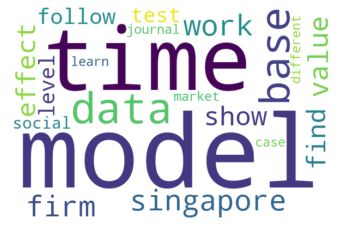

In [10]:
# Generate a word cloud image with top 20 words
wc = WordCloud(stopwords=stop_words, max_words=20, background_color="white", width=600, height=400)

# generate wordcloud from the frequencies
word_dict = {}
for x, y in fdist.most_common(20):
    word_dict[x] = int(y)

wordcloud = wc.generate_from_frequencies(word_dict)

# display wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Provide some further analysis and visualizations to illustrate some trends or unexpected insights you noticed about the data you have extracted from the API. e.g. Do certain terms become more popular over time? How would you interpret your answers? You are welcome to use NLP libraries like spaCy, NLTK, gensim, Fast.AI or any techniques you are familiar with in your answer. Feel free to supplement your data with other appropriate sources of data (e.g the full CORE data set) or APIs like Microsoft Academic Graph API. Crossref, Unpaywall**

To answer this question, let's first look at how the researched topic change over the years (starting from 2018, 2019, 2020) by examining their titles using NLTK

In [11]:
# Get titles of articles published in 2020, 2019, 2018
# Let's look at how the words used differ each year

papers_2020 = papers_df[papers_df["year"] == 2020]
papers_2019 = papers_df[papers_df["year"] == 2019]
papers_2018 = papers_df[papers_df["year"] == 2018]
print("Total articles retrieved for year 2020, 2019, and 2018 respectively:", papers_2020.shape[0], papers_2019.shape[0], papers_2018.shape[0])

# Pre-process the titles for each year
filtered_2020 = preprocess_text(papers_2020['title'])
filtered_2019 = preprocess_text(papers_2019['title'])
filtered_2018 = preprocess_text(papers_2018['title'])

Total articles retrieved for year 2020, 2019, and 2018 respectively: 785 1111 1255
Total 56849 words retrieved
Total 78933 words retrieved
Total 90437 words retrieved


* To find something more meaningful than just word frequency, let's get the top 10 bigram and trigram from each year

In [12]:
# find bigrams and trigrams for each year
ngrams2020, ngrams2019, ngrams2018 = dict(), dict(), dict()
for size in 2, 3:
    ngrams2020[size] = FreqDist(ngrams(filtered_2020, size))
    ngrams2019[size] = FreqDist(ngrams(filtered_2019, size))
    ngrams2018[size] = FreqDist(ngrams(filtered_2018, size))

# count the frequency distribution for each year too
fdist_2020 = FreqDist(filtered_2020)
fdist_2019 = FreqDist(filtered_2019)
fdist_2018 = FreqDist(filtered_2018)

print("Top 10 words for 2020: \n")
prt.pprint(fdist_2020.most_common(10))

print("\nTop 10 words for 2019: \n")
prt.pprint(fdist_2019.most_common(10))

print("\nTop 10 words for 2018: \n")
prt.pprint(fdist_2018.most_common(10))

Top 10 words for 2020: 

[('base', 41),
 ('learn', 39),
 ('covid', 33),
 ('data', 31),
 ('singapore', 28),
 ('model', 27),
 ('social', 24),
 ('market', 23),
 ('evidence', 23),
 ('test', 21)]

Top 10 words for 2019: 

[('base', 69),
 ('singapore', 54),
 ('social', 46),
 ('learn', 36),
 ('data', 33),
 ('effect', 31),
 ('time', 30),
 ('model', 28),
 ('law', 28),
 ('network', 26)]

Top 10 words for 2018: 

[('base', 65),
 ('singapore', 64),
 ('social', 57),
 ('learn', 52),
 ('data', 40),
 ('model', 38),
 ('online', 31),
 ('evidence', 31),
 ('new', 25),
 ('analysis', 25)]


In [13]:
# print the top 10 bigram and trigram for each year
print("Top 10 bigrams and trigrams for 2020: \n")
prt.pprint(ngrams2020[2].most_common(10))
prt.pprint(ngrams2020[3].most_common(10))

print("\n Top 10 bigrams and trigrams for 2019: \n")
prt.pprint(ngrams2019[2].most_common(10))
prt.pprint(ngrams2019[3].most_common(10))

print("\n Top 10 bigrams and trigrams for 2018: \n")
prt.pprint(ngrams2018[2].most_common(10))
prt.pprint(ngrams2018[3].most_common(10))

Top 10 bigrams and trigrams for 2020: 

[(('impact', 'covid'), 9),
 (('deep', 'learn'), 8),
 (('privacy', 'preserve'), 7),
 (('judgment', 'test'), 6),
 (('social', 'media'), 6),
 (('panel', 'data'), 5),
 (('situational', 'judgment'), 5),
 (('future', 'work'), 5),
 (('cyber', 'physical'), 5),
 (('fine', 'grain'), 5)]
[(('panel', 'data', 'model'), 4),
 (('situational', 'judgment', 'test'), 4),
 (('attribute', 'base', 'encryption'), 4),
 (('recognition', 'enforcement', 'foreign'), 3),
 (('young', 'launch', 'grow'), 3),
 (('launch', 'grow', 'digital'), 3),
 (('task', 'assignment', 'spatial'), 3),
 (('assignment', 'spatial', 'crowdsourcing'), 3),
 (('shale', 'shale', 'oil'), 2),
 (('shale', 'oil', 'global'), 2)]

 Top 10 bigrams and trigrams for 2019: 

[(('singapore', 'convention'), 10),
 (('corporate', 'social'), 7),
 (('attribute', 'base'), 7),
 (('large', 'scale'), 7),
 (('privacy', 'preserve'), 6),
 (('decision', 'make'), 6),
 (('social', 'media'), 6),
 (('hong', 'kong'), 6),
 (('conve

* Some bigrams and trigrams appear every year, albeit on different values. They are:

| Value/Year | 2018 | 2019 | 2020 |
|:----------:|:----:|:----:|:----:|
|privacy-preserve|11|6|7
|social-media|8|6|6
|hong-kong|6|6|0
|attribute-base|8|7|4
|large-scale|7|7|0
|attribute-base-encryption|5|0|4
|satisfaction-index-singapore|4|5|0

* Plot this in a chart so that it's easier to see

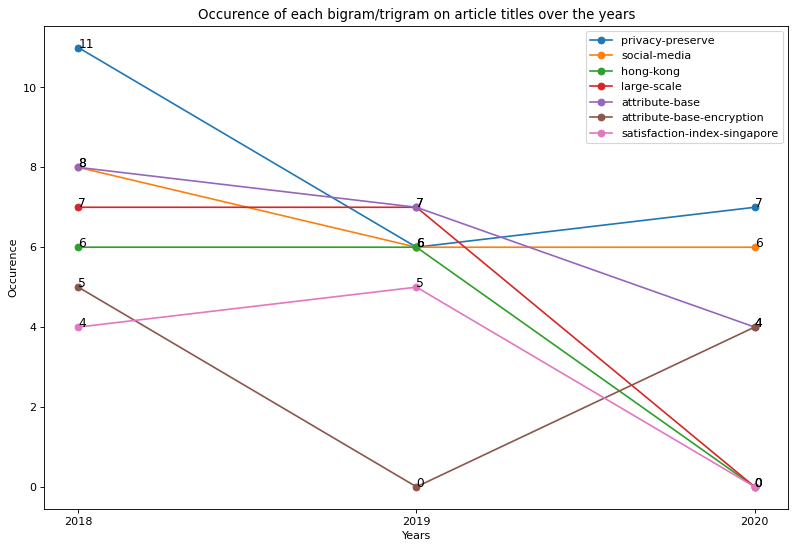

In [14]:
labels_x = ["2018", "2019", "2020"]
ngrams_dict = dict()
ngrams_dict["privacy-preserve"] = [11,6,7]
ngrams_dict["social-media"] = [8,6,6]
ngrams_dict["hong-kong"] = [6,6,0]
ngrams_dict["large-scale"] = [7,7,0]
ngrams_dict["attribute-base"] = [8,7,4]
ngrams_dict["attribute-base-encryption"] = [5,0,4]
ngrams_dict["satisfaction-index-singapore"] = [4,5,0]

# plotting with multiple lines 
plt.figure(figsize=(12,8), dpi= 80)
for key, value in ngrams_dict.items():
    plt.plot(labels_x, value, label = key, marker="o")
    for k, v in enumerate(value):
        plt.annotate(str(v), xy=(k,v), fontsize=11)

plt.xlabel('Years')
plt.ylabel('Occurence')
plt.title('Occurence of each bigram/trigram on article titles over the years')
plt.legend()
plt.show()

**Crosschecking the top 3 result above with Google Trends**

* The terms "attribute-based" and "large-scale" are more akin to descriptors and somewhat vague, so we will skip those.
* The keyword "Hong Kong" trended in 2018 and then it went up relatively higher on 2019, and dropped in 2020, similar to the bigrams chart 

![Google Trends on Hong Kong](gtrends_hk.jpg)

* The term "privacy preservation" or variations of it did not yield any result. However, the term "privacy" yield a result in as seen on the graph below. It shows a relatively stable interest over time. The same can also be said with the term "social media". This is reflected in the bigrams chart as well. 

![Google Trends on Privacy](gtrends_privacy.jpg)

![Google Trends on Social Media](gtrends_socmed.jpg)


**Compare topics of papers published on year 2018, 2019, and 2020**

In [15]:
# Get topic lists for each year
# 2018
filtered_2018 = cleanup_topics(papers_2018["topics"])
topics_2018_top10 = Counter(filtered_2018).most_common(10)
prt.pprint(topics_2018_top10)

# 2019
filtered_2019 = cleanup_topics(papers_2019["topics"])
topics_2019_top10 = Counter(filtered_2019).most_common(10)
prt.pprint(topics_2019_top10)

# 2020
filtered_2020 = cleanup_topics(papers_2020["topics"])
topics_2020_top10 = Counter(filtered_2020).most_common(10)
prt.pprint(topics_2020_top10)


[('Basic or Discovery Scholarship', 631),
 ('Applied or Integration/Application Scholarship', 322),
 ('Asian Studies', 204),
 ('Databases and Information Systems', 156),
 ('Data Science and Engineering', 138),
 ('Software Engineering', 137),
 ('Software and Cyber-Physical Systems', 85),
 ('Organizational Behavior and Theory', 81),
 ('Psychology', 73),
 ('Information Security', 69)]
[('Basic or Discovery Scholarship', 493),
 ('Applied or Integration/Application Scholarship', 292),
 ('Asian Studies', 195),
 ('Software Engineering', 130),
 ('Data Science and Engineering', 108),
 ('Databases and Information Systems', 106),
 ('Software and Cyber-Physical Systems', 102),
 ('Econometrics', 65),
 ('Finance and Financial Management', 62),
 ('Technology and Innovation', 59)]
[('Basic or Discovery Scholarship', 369),
 ('Applied or Integration/Application Scholarship', 203),
 ('Asian Studies', 149),
 ('Databases and Information Systems', 97),
 ('Data Science and Engineering', 90),
 ('Econometrics'

Topics that appear on all three years are:

| Topics/Year | 2018 | 2019 | 2020 |
|:----------:|:----:|:----:|:----:|
|Basic or Discovery Scholarship|631|493|369
|Applied or Integration/Application Scholarship|322|292|203
|Asian Studies|204|195|149
|Databases and Information Systems|156|106|97
|Data Science and Engineering|138|108|90
|Software Engineering|137|130|68
|Software and Cyber-Physical Systems|81|102|57

* "Econometrics" didn't make it to the top 10 in 2018, but appeared in the 2019 list and ranks even higher in 2020 list
* "Pyschology" , "Information Security", and "Organizational Behavior and Theory" only appeared in the top 10 of 2018
* "Finance and Financial Management" and "Technology and Innovation" only appeared in 2019 list
* "Finance" only appeared in 2020 list
* Generally the numbers of published paper went down each year, except for "Software and Cyber-Physical Systems" who experienced an increase in 2019. However

Map the information above into a chart:

<Figure size 1080x576 with 0 Axes>

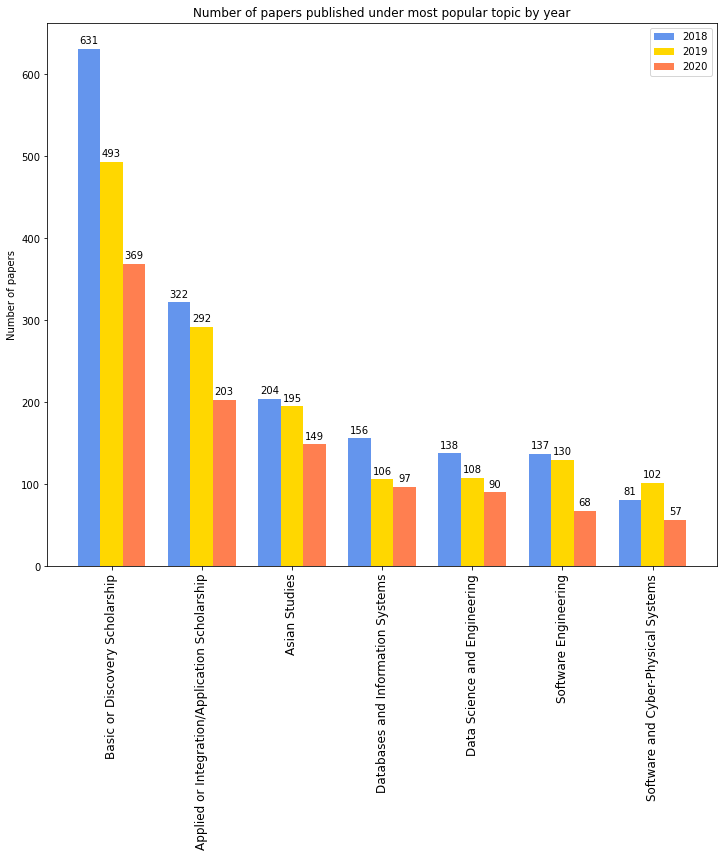

In [16]:
labels = ["Basic or Discovery Scholarship", "Applied or Integration/Application Scholarship", "Asian Studies", 
           "Databases and Information Systems", "Data Science and Engineering", "Software Engineering",
           "Software and Cyber-Physical Systems"]
topics_dict = dict()
topics_dict["2018"] = [631,322,204,156,138,137,81]
topics_dict["2019"] = [493,292,195,106,108,130,102]
topics_dict["2020"] = [369,203,149,97,90,68,57]

# barchart code from https://matplotlib.org/3.3.4/gallery/lines_bars_and_markers/barchart.html
plt.figure(figsize=(15,8))
fig, ax = plt.subplots(1,1, figsize=(12,10))
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

rect1 = ax.bar(x-width, topics_dict["2018"], color='cornflowerblue', width=width, align='center', label="2018")
rect2 = ax.bar(x, topics_dict["2019"], width=width, color='gold', align='center', label="2019")
rect3 = ax.bar(x+width, topics_dict["2020"], width=width, color='coral', align='center', label="2020")

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)

# labels for the chart
ax.set_ylabel('Number of papers')
ax.set_title('Number of papers published under most popular topic by year')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation="vertical")
ax.legend()

plt.show()

---

**Compare the records that have no full-text vs those that have full text. What differences do you see?**

Start with creating two dataframes for fulltext and non-fulltext articles

In [17]:
# separate into two dfs: ft (with full text) and noft (without full text)
ft_df = papers_df[papers_df["fullText"].notnull()]
noft_df = papers_df[papers_df["fullText"].notnull() == False]

* Examine and compare the topics for fulltext vs non-fulltext articles. 
* Illustrate in a graph for easier comparison

In [18]:
## fulltext topics
ft_topic_cleaned = cleanup_topics(ft_df["topics"])
ft_topic_count = Counter(ft_topic_cleaned).most_common(10)

print("Top {} topics for fulltext records:".format(len(ft_topic_count)))
prt.pprint(ft_topic_count)

## non-fulltext topics
noft_topic_cleaned = cleanup_topics(noft_df["topics"])
noft_topic_count = Counter(noft_topic_cleaned).most_common(10)

print("\nTop {} topics for non-fulltext records:".format(len(noft_topic_count)))
prt.pprint(noft_topic_count)


Top 10 topics for fulltext records:
[('Basic or Discovery Scholarship', 3651),
 ('Applied or Integration/Application Scholarship', 1294),
 ('Asian Studies', 1211),
 ('Databases and Information Systems', 885),
 ('Software Engineering', 780),
 ('Software and Cyber-Physical Systems', 640),
 ('Data Science and Engineering', 579),
 ('Econometrics', 538),
 ('Computer Sciences', 500),
 ('Not Applicable', 431)]

Top 10 topics for non-fulltext records:
[('Basic or Discovery Scholarship', 1543),
 ('Asian Studies', 685),
 ('Applied or Integration/Application Scholarship', 557),
 ('Business', 297),
 ('Not Applicable', 243),
 ('Accounting', 241),
 ('Political Science', 230),
 ('Organizational Behavior and Theory', 225),
 ('Organisational Behaviour and Human Resources', 223),
 ('Singapore', 182)]


<ipython-input-19-5c2b889ac429>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ft_labels, fontsize=12)
<ipython-input-19-5c2b889ac429>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(noft_labels, fontsize=12)


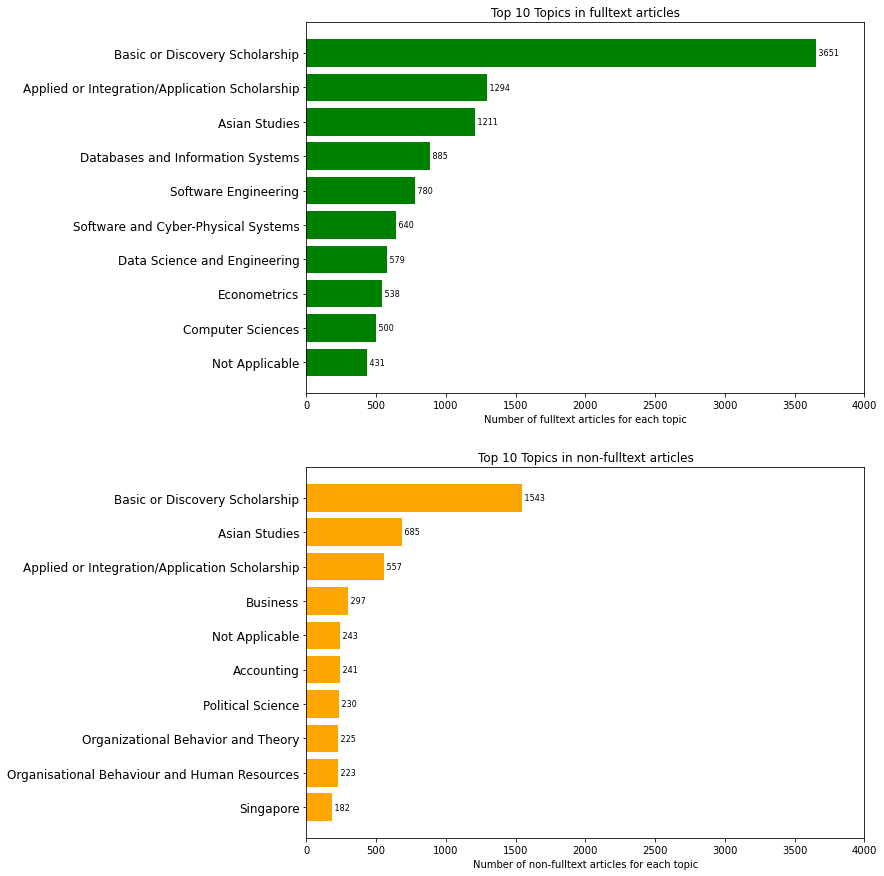

In [19]:
# Draw a graph to compare both
fig1 = plt.figure(figsize=(10,15)) # create the graph "container"
ax1 = fig1.add_subplot(211) # 2 rows 1 column graph 1
ax2 = fig1.add_subplot(212) # 2 rows 1 column graph 2

# ----Draw the full text graph----
ft_labels = []
ft_values = []
for item in ft_topic_count:
    ft_labels.append(item[0])
    ft_values.append(item[1])

ftlabels_pos = np.arange(len(ft_labels)) # the x locations for the groups  
ax1.barh(ftlabels_pos, ft_values, align='center', color="green") # setup horizontal bar chart
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Number of fulltext articles for each topic')
ax1.set_title('Top 10 Topics in fulltext articles')
for i, v in enumerate(ft_values): # insert value labels for easy readibility
    ax1.text(v, i, " "+str(v), va='center', fontsize=8)
ax1.set_yticklabels(ft_labels, fontsize=12)
ax1.set_yticks(ftlabels_pos)
ax1.set_xlim([None,4000]) # set max limit for the x-axis
    
# ----Draw the non-fulltext graph----
noft_labels = []
noft_values = []
for item in noft_topic_count:
    noft_labels.append(item[0])
    noft_values.append(item[1])

noftlabels_pos = np.arange(len(noft_labels)) # the x locations for the groups  
ax2.barh(noftlabels_pos, noft_values, align='center', color="orange") # setup horizontal bar chart
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('Number of non-fulltext articles for each topic')
ax2.set_title('Top 10 Topics in non-fulltext articles')
for i, v in enumerate(noft_values): # insert value labels for easy readibility
    ax2.text(v, i, " "+str(v), va='center', fontsize=8)
ax2.set_yticklabels(noft_labels, fontsize=12)
ax2.set_yticks(noftlabels_pos)
ax2.set_xlim([None,4000]) # set max limit for the x-axis

# ----Show graphs----
plt.show()

The first three topics appear on the list for fulltext and non-fulltext articles.

At a glance, it seems like there are more non-fulltext articles for social sciences topics. Let's check what are the ratio of fulltext vs non-fulltext for Accounting, Political Science, Organizational Behavior and Theory, and Organisational Behaviour and Human Resources.

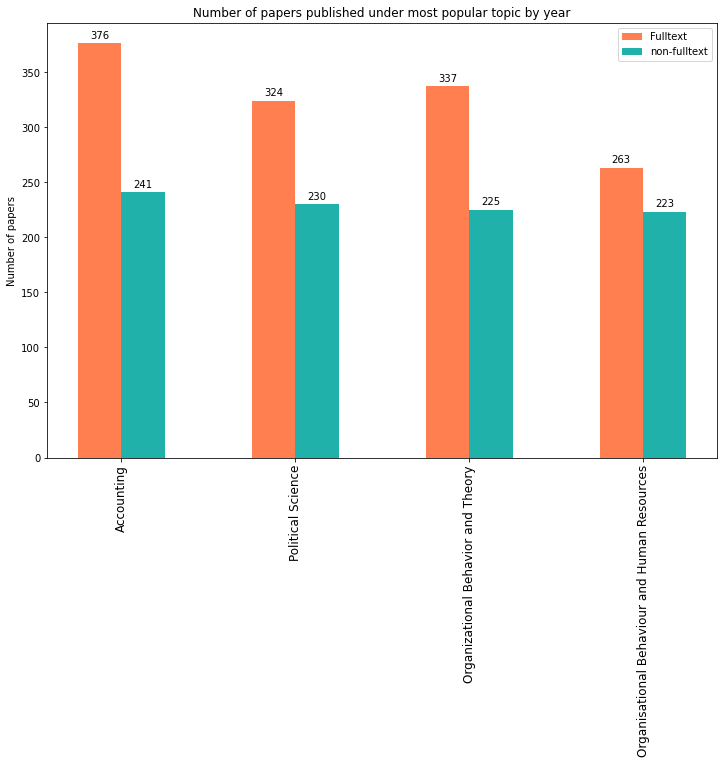

In [20]:
count_4topic_ft = Counter(ft_topic_cleaned)
count_4topic_noft = Counter(noft_topic_cleaned)
labels = ["Accounting", "Political Science", 
          "Organizational Behavior and Theory", "Organisational Behaviour and Human Resources"]

papers_ft, papers_noft = [], []
for label in labels:
    papers_ft.append(count_4topic_ft[str(label)])
    papers_noft.append(count_4topic_noft[str(label)])

# barchart code from https://matplotlib.org/3.3.4/gallery/lines_bars_and_markers/barchart.html
fig, ax = plt.subplots(1,1, figsize=(12,8))
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

rect1 = ax.bar(x-width/2, papers_ft, color='coral', width=width, align='center', label="Fulltext")
rect2 = ax.bar(x+width/2, papers_noft, width=width, color='lightseagreen', align='center',
               label="non-fulltext")

autolabel(rect1)
autolabel(rect2)

# labels for the chart
ax.set_ylabel('Number of papers')
ax.set_title('Number of papers published under most popular topic by year')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation="vertical")
ax.legend()

plt.show()

Interestingly, the numbers for fulltext submission are more varied as compared to the number of non-fulltext submission. Even though there are more fulltext across all the four topics, they are still at the lower end.

Next:

* Examine the submission rate for both fulltext and non-fulltext articles each year
* Plot them in a graph for easier comparison

In [21]:
years = ft_df["year"].unique().tolist()
yearly_count_ft, yearly_count_noft = dict(), dict()

for year in years:
    yearly_count_ft[str(year)] = ft_df[ft_df["year"] == year].shape[0]
    yearly_count_noft[str(year)] = noft_df[noft_df["year"] == year].shape[0]

prt.pprint(yearly_count_ft)    
prt.pprint(yearly_count_noft) 


{'2012': 1,
 '2013': 833,
 '2014': 836,
 '2015': 919,
 '2016': 898,
 '2017': 1016,
 '2018': 1005,
 '2019': 748,
 '2020': 437,
 '2021': 12}
{'2012': 12,
 '2013': 537,
 '2014': 721,
 '2015': 434,
 '2016': 382,
 '2017': 241,
 '2018': 250,
 '2019': 363,
 '2020': 348,
 '2021': 7}


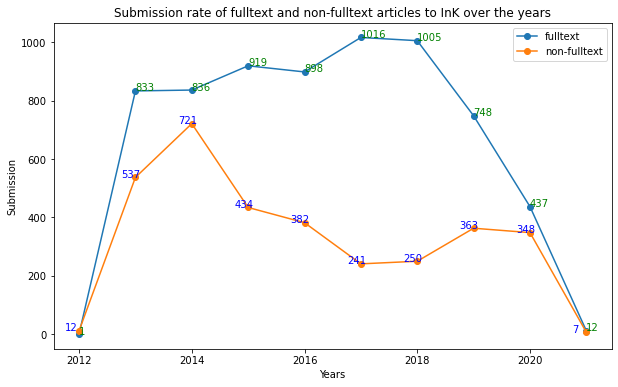

In [22]:
# Plotting the graph
# prepare the dict for the graph
ycount_ft_values = list(yearly_count_ft.values())
ycount_noft_values = list(yearly_count_noft.values())

plt.figure(figsize=(10,6))

plt.plot(years, ycount_ft_values, label = "fulltext", marker="o")
for k, v in yearly_count_ft.items():
    plt.annotate(str(v), xy=(int(k),v), color="g")
    
plt.plot(years, ycount_noft_values, label = "non-fulltext", marker="o")
for k, v in yearly_count_noft.items():
    plt.annotate(str(v), xy=(int(k)-0.25,v), color="b")

plt.xlabel('Years')
plt.ylabel('Submission')
plt.title('Submission rate of fulltext and non-fulltext articles to InK over the years')
plt.legend()
plt.show()

The submission rate for both types seems to be going down starting from 2018 onwards. It took quite a dip in 2019 and even more in 2020. Among the papers submitted in 2019, there are more non-fulltext compared to 2018. The ratio of fulltext vs non-fulltext submission also increased in 2020.

As I understand it, there were a leadership transition in 2019 and this might have contributed to the dip in submission numbers somehow. The drop in 2020 may be attributed to the COVID-19 situation.